In [49]:
%load_ext autoreload
%autoreload 2

from gwak.train.dataloader import SignalDataloader
from pathlib import Path
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import lightning.pytorch as pl
import yaml
from tqdm import tqdm
from ml4gw.transforms import SpectralDensity, Whiten
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
data_dir = "/home/katya.govorkova/gwak2/gwak/output/O4_MDC_background/HL"
# data_dir = "/home/hongyin.chen/Data/GWAK_data/gwak_inspect_4K"
sample_rate = 4096
kernel_length = 0.5
psd_length = 64
fduration = 1
fftlength = 2
batch_size = 1024
batches_per_epoch = 50
num_workers = 2
data_saving_file = None
duration = fduration + kernel_length

from gwak.data.prior import SineGaussianBBC, LAL_BBHPrior, GaussianBBC, CuspBBC, KinkBBC, KinkkinkBBC, WhiteNoiseBurstBBC
from ml4gw.waveforms import SineGaussian, IMRPhenomPv2, Gaussian, GenerateString, WhiteNoiseBurst

signal_classes = [
    "SineGaussian",
    "BBH",
    "Gaussian",
    "Cusp",
    "Kink",
    "KinkKink",
    "WhiteNoiseBurst",
    "Background"
]
priors = [
    SineGaussianBBC(),
    LAL_BBHPrior(),
    GaussianBBC(),
    CuspBBC(),
    KinkBBC(),
    KinkkinkBBC(),
    WhiteNoiseBurstBBC(),
    None
]
waveforms = [
    SineGaussian(
        sample_rate=sample_rate,
        duration=duration
    ),
    IMRPhenomPv2(),
    Gaussian(
        sample_rate=sample_rate,
        duration=duration
    ),
    GenerateString(
        sample_rate=sample_rate
    ),
    GenerateString(
        sample_rate=sample_rate
    ),
    GenerateString(
        sample_rate=sample_rate
    ),
    WhiteNoiseBurst(
        sample_rate=sample_rate,
        duration=duration
    ),
    None
]
extra_kwargs = [
    None,
    {"ringdown_duration":0.9},
    None,
    None,
    None,
    None,
    None,
    None
]

In [51]:
loader = SignalDataloader(signal_classes,
    priors,
    waveforms,
    extra_kwargs,
    data_dir=data_dir,
    sample_rate=sample_rate,
    kernel_length=kernel_length,
    psd_length=psd_length,
    fduration=fduration,
    fftlength=fftlength,
    batch_size=batch_size,
    batches_per_epoch=batches_per_epoch,
    num_workers=num_workers,
    data_saving_file=data_saving_file
)
test_loader = loader.test_dataloader()

/home/katya.govorkova/miniconda3/envs/gwak/lib/python3.11/site-packages/ml4gw/dataloading/hdf5_dataset.py:83: ContiguousHdf5Warning: File /home/katya.govorkova/gwak2/gwak/output/O4_MDC_background/HL/background-1402686754-28601.h5 contains datasets that were generated without using chunked storage. This can have severe performance impacts at data loading time. If you need faster loading, try re-generating your datset with chunked storage turned on.
  warnings.warn(
/home/katya.govorkova/miniconda3/envs/gwak/lib/python3.11/site-packages/ml4gw/dataloading/hdf5_dataset.py:83: ContiguousHdf5Warning: File /home/katya.govorkova/gwak2/gwak/output/O4_MDC_background/HL/background-1403697272-13408.h5 contains datasets that were generated without using chunked storage. This can have severe performance impacts at data loading time. If you need faster loading, try re-generating your datset with chunked storage turned on.
  warnings.warn(
/home/katya.govorkova/miniconda3/envs/gwak/lib/python3.11/site

In [52]:
# /home/katya.govorkova/gwak2/gwak
embed_model_path = "/home/hongyin.chen/anti_gravity/gwak/gwak/output/S4_SimCLR_multiSignalAndBkg_HL/model_JIT.pt"
embed_model = torch.jit.load(embed_model_path).to(device)
embed_model.eval()

metric_model_path = "/home/hongyin.chen/anti_gravity/gwak/gwak/output/S4_SimCLR_multiSignalAndBkg_NF_onlyBkg_HL/model_JIT.pt"
metric_model_path = "/home/katya.govorkova/gwak2/gwak/output/S4_SimCLR_multiSignalAndBkg_NF_onlyBkg_HL/model_JIT.pt"
metric_model = torch.jit.load(metric_model_path).to(device)
metric_model.eval()

combined_model_path = "/home/hongyin.chen/anti_gravity/gwak/gwak/output/combination/model_JIT.pt"
combined_model = torch.jit.load(combined_model_path).to(device)
combined_model.eval()


# Containers to store anomaly scores and binary labels
all_scores = []
c_all_scores = []
all_binary_labels = []
all_labels = []
all_snrs = []
all_embeddings = []

# Iterate over the test data loader
niter = 1
for ib in range(niter):
    print(f"iter {ib+1}/{niter}")
    for batch in tqdm(test_loader):
        [batch] = batch
        # Generate the corresponding waveforms
        waveforms, params, ras, decs, phics = loader.generate_waveforms(batch.shape[0])
        batch = batch.to(device)

        # Process the waveforms into the required input format
        x, snrs = loader.multiInject_SNR(waveforms, batch)

        # Reconstruct the ground truth multi-class labels
        labels = torch.cat([(i+1)*torch.ones(loader.num_per_class[i]) for i in range(loader.num_classes)]).to(device)

        with torch.no_grad():
            # print(x)
            z = embed_model(x.to(device))
            # print(f"{z = }")
            scores = metric_model(z).squeeze().cpu().numpy()
            # print(f"{scores = }")
            # The combined model directly outputs the anomaly score

            c_scores = combined_model(x.to(device)).squeeze().cpu().detach().numpy()
            #scores = combined_model(x.to(device)).squeeze()  # (batch_size,)
            #scores = scores.cpu().numpy()
            # Invert the scores so that higher values correspond to more anomalous behavior
            scores = -scores
            c_scores = -c_scores

        # Convert the multi-class labels to binary labels:
        # Treat "Background" (assumed to be label 8) as 0 (normal) and all other classes as 1 (anomaly)
        binary_labels = (labels != 8).cpu().numpy()

        all_scores.append(scores)
        c_all_scores.append(c_scores)
        all_binary_labels.append(binary_labels)
        all_labels.append(labels.cpu().numpy())
        all_snrs.append(snrs.cpu().numpy())
        all_embeddings.append(z.cpu().detach().numpy())

# Concatenate scores and labels across batches
all_scores = np.concatenate(all_scores)
c_all_scores = np.concatenate(c_all_scores)
all_binary_labels = np.concatenate(all_binary_labels)
all_labels = np.concatenate(all_labels)
all_snrs = np.concatenate(all_snrs)
all_embeddings = np.concatenate(all_embeddings)

iter 1/1


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [05:56<00:00,  7.12s/it]


## use nf scores

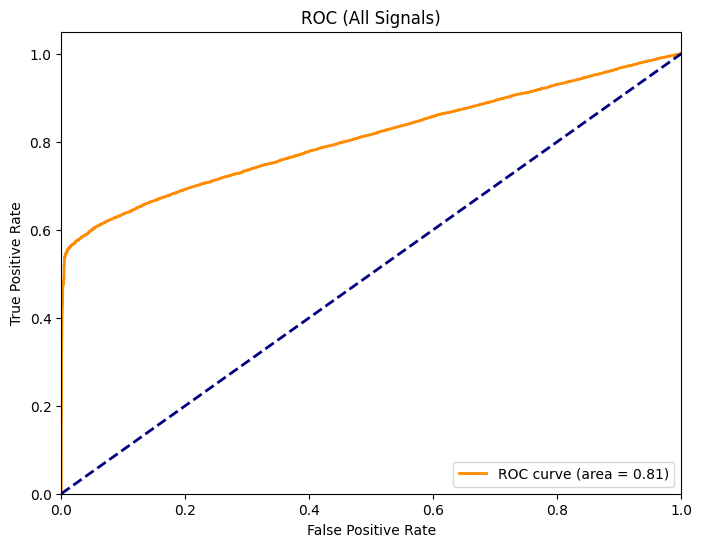

In [53]:
# Compute the ROC curve and AUC using scikit-learn
fpr, tpr, thresholds = roc_curve(all_binary_labels, all_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC (All Signals)")
plt.legend(loc="lower right")
plt.savefig("roc_combined.png")
plt.show()

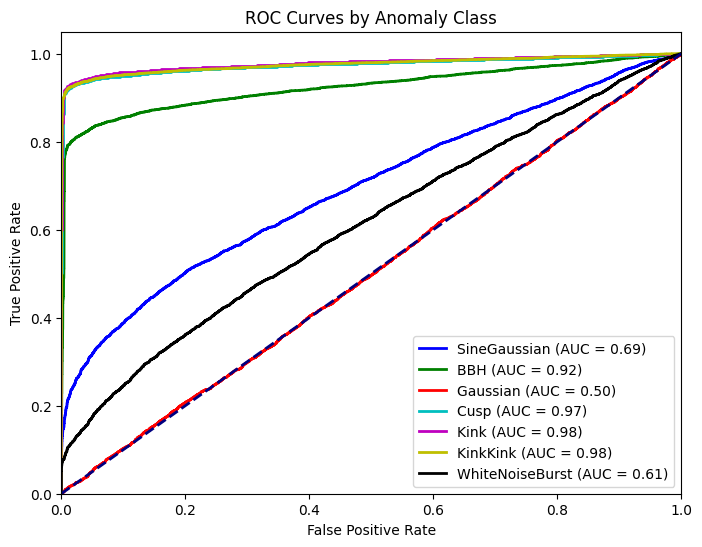

In [54]:
# Compute and plot ROC curves for each anomaly class (all but "Background").

plt.figure(figsize=(8,6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Colors for each anomaly class

for i, anomaly_class in enumerate(signal_classes[:-1]):  # Exclude "Background"
    # The anomaly class numeric label is i+1.
    anomaly_val = i + 1
    # Filter to only examples that are either the current anomaly class or Background (label 8).
    idx = np.where((all_labels == anomaly_val) | (all_labels == 8))[0]
    if idx.size == 0:
        continue  # skip if no examples
    scores_i = all_scores[idx]
    # Create binary ground truth: positive if the example is of the current anomaly class, 0 if background.
    binary_labels = (all_labels[idx] == anomaly_val).astype(int)
    
    # Compute the ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(binary_labels, scores_i)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color=colors[i % len(colors)], lw=2,
             label=f"{anomaly_class} (AUC = {roc_auc:.2f})")

# Plot reference line (diagonal)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.xscale('log')
plt.title("ROC Curves by Anomaly Class")
plt.legend(loc="lower right")
plt.savefig("rocs_bySignal.png")
plt.show()

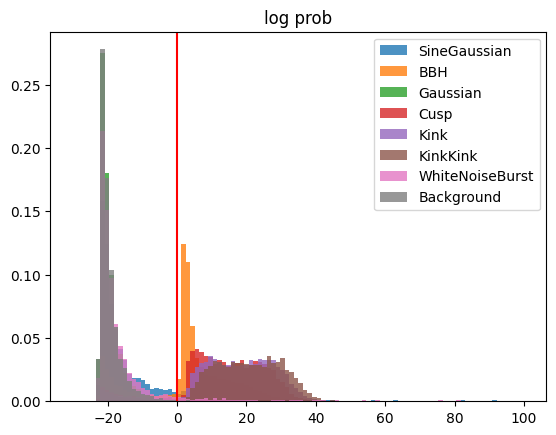

In [55]:
segment_duration = 0.5
year_sec = 3.154e7

fraction_1yr = (1.0 / year_sec) * segment_duration
# # Extract background-only data
bg_mask = (all_labels == 8)
bg_scores = all_scores[bg_mask]
c_bg_scores = c_all_scores[bg_mask]
threshold_1yr= np.quantile(bg_scores,1-fraction_1yr)

threshold_1yr = 0
# threshold_1yr = 0
plt.title("log prob")

for i, sig in enumerate(signal_classes):
    plt.hist(all_scores[(all_labels == i+1)], bins=100, alpha=0.8, label=sig, range=(-30,100), density=True)
# plt.hist(c_bg_scores,bins=100, alpha=0.5)
# plt.hist(bg_scores,bins=100, label='background', alpha=0.5)
plt.axvline(threshold_1yr,color='red')
# plt.yscale('log')
plt.legend(loc='best')

SineGaussian [ 48.844624   -4.394001   -8.4524975 ...   5.6476555 -19.73346
 -20.535309 ]
BBH [ 2.3707952 15.269034   1.4904938 ...  2.8417282 11.478399  15.679359 ]
Gaussian [-22.389227 -19.347977 -21.525164 ... -18.612032 -16.774359 -17.649677]
Cusp [20.51976    7.7895317  3.189746  ... 25.157175   9.025684  27.11097  ]
Kink [32.368534 23.154884  8.59996  ...  9.22731  28.892673 22.627838]
KinkKink [-13.686285   5.505272  14.510128 ...  32.56682  -10.121555  35.20225 ]
WhiteNoiseBurst [-21.619057  -19.546896  -21.91355   ...  -4.4665604  -3.7970734
 159.71013  ]


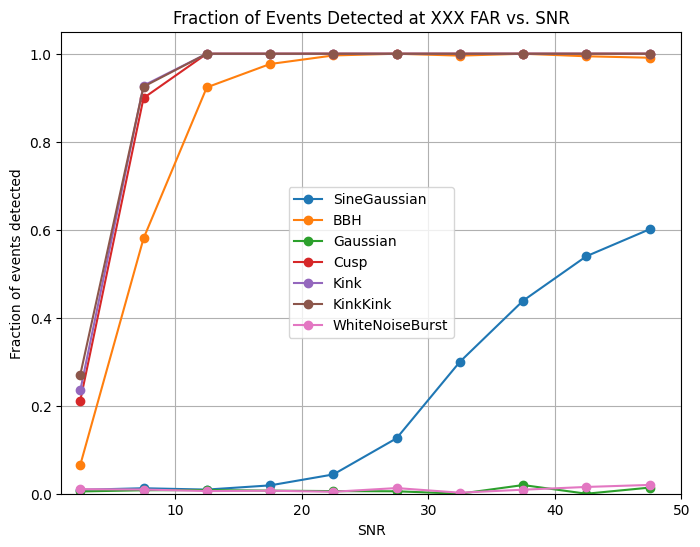

In [56]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
# -----------------------------------------------------------------------------
# 3) BIN ANOMALIES BY SNR AND COMPUTE FRACTION DETECTED (SCORE > threshold_1yr)
# -----------------------------------------------------------------------------

# We'll define 10 bins in SNR from the minimum anomaly SNR to the maximum
# anomaly SNR across all anomaly classes (labels 1..7).
anom_mask = (all_labels != 8)
# if np.any(anom_mask):
#     snr_min, snr_max = all_snrs[anom_mask].min(), all_snrs[anom_mask].max()
# else:
#     raise ValueError("No anomaly samples found in the test set!")

snr_min, snr_max = 1, 50

num_bins = 10
# bin_edges = np.logspace(0, 2, num_bins + 1)
bin_edges = np.linspace(0, 50, num_bins + 1)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

plt.figure(figsize=(8,6))

for i, anom_class_name in enumerate(signal_classes[:-1]):
    class_label = i + 1  # classes are 1..7
    mask = (all_labels == class_label)
    if not np.any(mask):
        # If no samples for that class, skip
        continue

    class_scores = all_scores[mask]
    class_snrs = all_snrs[mask]

    # Bin by SNR
    bin_idx = np.digitize(class_snrs, bin_edges) - 1  # bin indices in [0..num_bins-1]

    frac_detected = []
    for b in range(num_bins):
        in_bin = (bin_idx == b)
        if not np.any(in_bin):
            frac_detected.append(np.nan)  # or 0.0 if you prefer
        else:
            # fraction that exceed threshold
            frac = np.mean(class_scores[in_bin] > threshold_1yr)
            frac_detected.append(frac)

    print(anom_class_name, class_scores)
    plt.plot(bin_centers, frac_detected, marker='o', label=anom_class_name)

plt.xlabel("SNR")
plt.ylabel("Fraction of events detected")
plt.title("Fraction of Events Detected at XXX FAR vs. SNR")
plt.ylim([0, 1.05])
plt.xlim([1, 50])
plt.legend()
plt.grid(True)
plt.show()

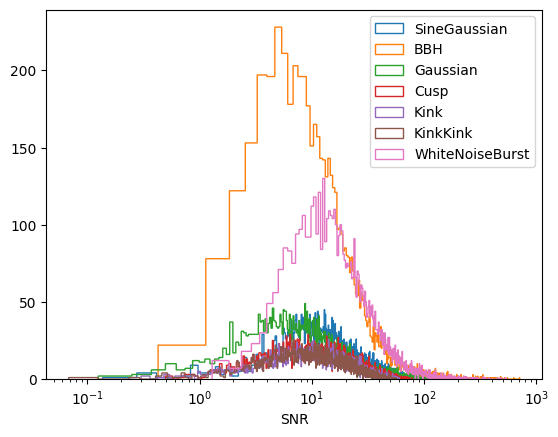

In [57]:
bins = np.logspace(1,7,100)
for i,sig in enumerate(signal_classes[:-1]):
    h=plt.hist(all_snrs[all_labels==i+1],bins=1000,label=sig,histtype='step')
#plt.yscale('log')
plt.xscale('log')
plt.xlabel("SNR")
plt.legend()

In [58]:
for i, sig in enumerate(signal_classes[:-1]):
    snr_min, snr_max = 0, 0
    anom_mask = (all_labels == i+1)
    snr_min, snr_max = all_snrs[anom_mask].min(), all_snrs[anom_mask].max()
    print(sig, snr_min, snr_max)

SineGaussian 0.13707349 138.69736
BBH 0.42661667 709.15533
Gaussian 0.124983124 123.71134
Cusp 0.4966296 78.047195
Kink 0.30093336 60.22665
KinkKink 0.06809459 56.207195
WhiteNoiseBurst 1.2930838 534.64404


In [59]:
for i, sig in enumerate(signal_classes[:-1]):
    snr_min, snr_max = 0, 0
    anom_mask = (all_labels == i+1)
    snr_min, snr_max = all_snrs[anom_mask].min(), all_snrs[anom_mask].max()
    print(sig, snr_min, snr_max)

SineGaussian 0.13707349 138.69736
BBH 0.42661667 709.15533
Gaussian 0.124983124 123.71134
Cusp 0.4966296 78.047195
Kink 0.30093336 60.22665
KinkKink 0.06809459 56.207195
WhiteNoiseBurst 1.2930838 534.64404
